In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs, remove
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import kendalltau
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
from nilearn.mass_univariate import permuted_ols

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [9]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [10]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [11]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [12]:
hem = 'L'

In [13]:
list_sn = su.get_list_sn()

---

In [14]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [15]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [16]:
dir_group = join(dir_surf,'group')

---

## Define searchlight function

In [17]:
## re-arranged index
idx_arr = [0,2,4,6,1,3,5,7]

In [18]:
def return_mat(model):
    N = 8
    mat = np.ones((N,N)) * np.nan
    mat_arr = np.ones((N,N)) * np.nan
    for row in range(N):
        for col in range(N):
            if model == 'diff_cue':
                ## 1. different cue
                if row%2 != col%2:
                    mat[row,col] = 1
            elif model == 'finger_same-diff':
                ## 2. finger_sama-diff
                if (row//4-0.5)*(col//4-0.5)<0:
                    mat[row,col] = -1
                if (row//4-0.5)*(col//4-0.5)>0:
                    mat[row,col] = 1
            elif model == 'finger_diff':
                ## 3. finger_diff
                if (row//4-0.5)*(col//4-0.5)<0:
                    mat[row,col] = 1
            elif model == 'letter':
                ## 4. letter
                if (row%2==0)&(col%2==0):
                    mat[row,col] = 1./12
            elif model == 'spatial':
                ## 5. spatial
                if (row%2==1)&(col%2==1):
                    mat[row,col] = 1./12
            elif model == 'across':
                ## 6. across cue
                if (row==col-1)&(row%2==0):
                    mat[row,col] = -1./4
                elif (row%2==0)&(col%2==1)&(row+1!=col):
                    mat[row,col] = 1./12
                    
    
    ## post-processing
    mat_arr = np.copy(mat)
    mat_arr = mat_arr[idx_arr][:,idx_arr]
    for row in range(N):
        for col in range(N):
            if row==col:
                mat[row,col] = np.nan
                mat_arr[row,col] = np.nan

    return mat, mat_arr

In [19]:
reginfo = deal_spm.load_reginfo(subj='S01', dir_glm=dir_glm)
conditions = np.array(sorted(reginfo.name.unique()))

---
---

In [20]:
# model = 'diff_cue'
# model = 'finger_same-diff'
# model = 'finger_diff'
# model = 'letter'
# model = 'spatial'
model = 'across'

[Text(0, 0.5, '(1,L)'),
 Text(0, 1.5, '(2,L)'),
 Text(0, 2.5, '(3,L)'),
 Text(0, 3.5, '(4,L)'),
 Text(0, 4.5, '(1,S)'),
 Text(0, 5.5, '(2,S)'),
 Text(0, 6.5, '(3,S)'),
 Text(0, 7.5, '(4,S)')]

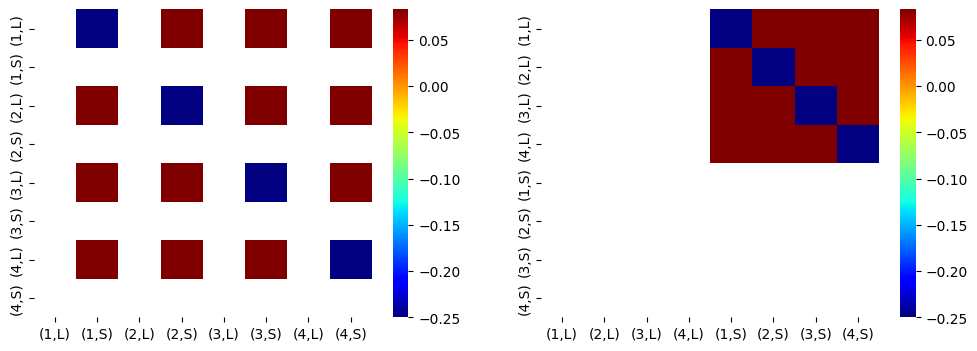

In [21]:
mat, mat_arr = return_mat(model)

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
ax = axs[0]
sns.heatmap(mat, cmap=cm.jet, ax=ax)
ax.set_xticklabels(conditions)
ax.set_yticklabels(conditions)
ax = axs[1]
sns.heatmap(mat_arr, cmap=cm.jet, ax=ax)
ax.set_xticklabels(conditions[idx_arr])
ax.set_yticklabels(conditions[idx_arr])

In [22]:
print(np.nansum(mat[mat>0]), np.nansum(mat[mat<0]))
assert np.nansum(mat[mat>0])==1
assert (np.nansum(mat[mat<0])==-1)|(np.nansum(mat[mat<0])==0)

1.0 -1.0


---

### Model RDM for across-cue

In [23]:
def return_mat_model(model):
    N = 8
    mat_model = np.ones((N,N)) * np.nan
    for row in range(N):
        for col in range(N):
            if model=='letter':
                if (row<4)&(col<4):
                    if row==col:
                        mat_model[row][col] = 0
                    else:
                        mat_model[row][col] = 1
            elif model=='spatial':
                if (row>=4)&(col>=4):
                    if row==col:
                        mat_model[row][col] = 0
                    else:
                        mat_model[row][col] = 1
            elif model=='across':
                if (row<4)&(col>=4):
                    if row+4==col:
                        mat_model[row][col] = 0
                    else:
                        mat_model[row][col] = 1
    
    return mat_model

[Text(0, 0.5, '(1,L)'),
 Text(0, 1.5, '(1,S)'),
 Text(0, 2.5, '(2,L)'),
 Text(0, 3.5, '(2,S)'),
 Text(0, 4.5, '(3,L)'),
 Text(0, 5.5, '(3,S)'),
 Text(0, 6.5, '(4,L)'),
 Text(0, 7.5, '(4,S)')]

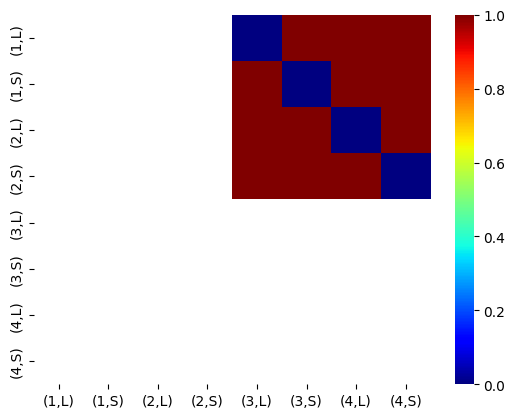

In [24]:
mat_model = return_mat_model(model)
g = sns.heatmap(mat_model, cmap=cm.jet)
g.set_xticklabels(conditions)
g.set_yticklabels(conditions)

In [25]:
def vec_upper_tri(mat, k=1):
    N = mat.shape[0]
    idx = np.triu_indices(N, k=k) # k=1 : off-diagonal sum
    return mat[idx]

---
---

In [26]:
# Define the MVPA function that will be used in the searchlight
# The functions take a n_images x n_voxels array as input.
# and return either a scalar or vector as output.
# Here we use simple example that calculate the mean activity in the searchlight region.
def func_Dist(data, **kwargs):
    obs_des = {
        'cond_vec': kwargs['cond_vec'],
        'part_vec': kwargs['part_vec'],
        # 'cue': kwargs['cue']
    }
    
    ## set the dataset
    Y = pcm.dataset.Dataset(
        measurements=data,
        obs_descriptors=obs_des
    )
    ## the second moment matrix G
    G_hat, _ = pcm.est_G_crossval(
        Y=Y.measurements,
        Z=Y.obs_descriptors['cond_vec'],
        part_vec=Y.obs_descriptors['part_vec'],
        X=pcm.matrix.indicator(Y.obs_descriptors['part_vec'])
    )
    dist = pcm.G_to_dist(G_hat)
    
    ## i) get the average distance
    tmp = dist * mat
    result = np.nansum(tmp)

    ## ii) Kendall's tau
    # vec1 = vec_upper_tri(dist)
    # vec2 = vec_upper_tri(mat_model)
    # tau, pval = kendalltau(vec1, vec2, variant='b', nan_policy='omit')
    # result = tau
    
    return result

In [27]:
def getback_vec(reginfo):
    part_vec = reginfo.run.values
    cond_vec = np.array(
        [
            2*(int(num)-1) + (0 if ch == "L" else 1) + 1
            for num, ch in (item.strip("()").split(",") for item in reginfo.name)
        ]
    )
    return part_vec, cond_vec

In [28]:
# reginfo = deal_spm.load_reginfo(subj='S01', dir_glm=dir_glm)
# reginfo

## Run Searchlight

In [29]:
dir_output = join(dir_surf,'glm_%1d'%glm)
exists(dir_output)

True

In [30]:
for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn

    ## We can now use the pre-computed searchlight.
    nvoxel = 200
    fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=%d.h5'%(subj,hem,nvoxel))
    mySearchlight = sl.load(fname)
    # print(f'Average size of the searchlight: {mySearchlight.radius.mean():.1f} mm')
    # print(f'Average number of voxels: {mySearchlight.nvoxels.mean():.1f}')
    
    dir_work = join(dir_glm,'surfaceWB',subj)

    ## load reginfo.tsv
    reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
    part_vec, cond_vec = getback_vec(reginfo)
    obs_des = {
        'part_vec': part_vec, 'cond_vec': cond_vec,
        # 'cue':cue
    }

    ## set betas
    dataset = [join(dir_glm,subj,'beta_%04d.nii'%(ii+1)) for ii in range(len(cond_vec))]
    
    ## Run the searchlight with the defined scalar MVPA function
    results = mySearchlight.run(dataset, func_Dist, obs_des, verbose=False)

    ## save the result
    fname = join(dir_output,subj,'%s.%s.glm_%d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,model))
    if exists(fname):
        remove(fname)
    mySearchlight.data_to_cifti(results, outfilename=fname)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [1:01:41<00:00, 308.42s/it]


---

## Save the group result

### Load individual data

In [31]:
# model = 'across'

In [32]:
dataset = np.ones((len(list_sn),32492)) * np.nan
for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn

    ## load the result
    fname = join(dir_surf,'glm_%1d'%glm,subj,'%s.%s.glm_%d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,model))
    # if not exists(fname):
    #     continue
    cifti = nb.load(fname)
    
    ## load the setup file
    # nvoxel = 100 if not subj=='S02' else 70
    nvoxel = 200
    fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=%d.h5'%(subj,hem,nvoxel))
    mySearchlight = sl.load(fname)

    ## check the indeces of centers
    idx = mySearchlight.center_indx
    dataset[ii,idx] = cifti.get_fdata()
    
    del cifti, mySearchlight

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:56<00:00,  4.74s/it]


### Save the dataset as cifti

In [33]:
dir_output = join(dir_surf,'glm_%1d'%glm)
simage.save_surf2cifti(
    data=dataset,
    dir_output=dir_output,
    label_axis=['S'+sn for sn in list_sn],
    prefix='cifti.%s.glm_%1d.searchlight.mean_dist.%s'%(hem,glm,model)
)

### t-test

In [34]:
# one-sample test: constant predictor
tested_vars = np.ones((12, 1))

In [35]:
fname = join(dir_surf,'glm_%1d'%glm,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,model))
data = nb.load(fname).get_fdata()

In [36]:
# permutation test
res = permuted_ols(
    tested_vars=tested_vars,
    target_vars=data,
    n_perm=10000,
    two_sided_test=True,
    n_jobs=1,
    output_type="dict"
)
tmap = res['t'].reshape(-1)   

In [37]:
dataset = np.ones((2,32492)) * np.nan
dataset[0,:] = np.mean(data, axis=0)
dataset[1,:] = tmap
simage.save_surf2cifti(
    data=dataset,
    dir_output=dir_group,
    label_axis=['mean','t'],
    prefix='cifti.%s.glm_%1d.searchlight.mean_dist.%s'%(hem,glm,model)
)

---
---

## Plot the result

In [26]:
dir_work = join(dir_group)
glob(join(dir_work,'*mean_dist*'))

['/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_1.searchlight.mean_dist.across.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_1.searchlight.mean_dist.letter.dscalar.nii',
 '/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_1.searchlight.mean_dist.spatial.dscalar.nii']

In [27]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

In [28]:
alternative = 'one-sided'
thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=len(list_sn)-1, alternative=alternative)

In [50]:
def get_RDM(model, thresh):
    fname = join(dir_work,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,model))
    data = np.array(nb.load(fname).get_fdata()) 

    ## thresholding
    idx = data[1] >= thresh
    ds = data[0].copy()
    ds[~idx] = np.nan

    return ds

100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.26it/s]


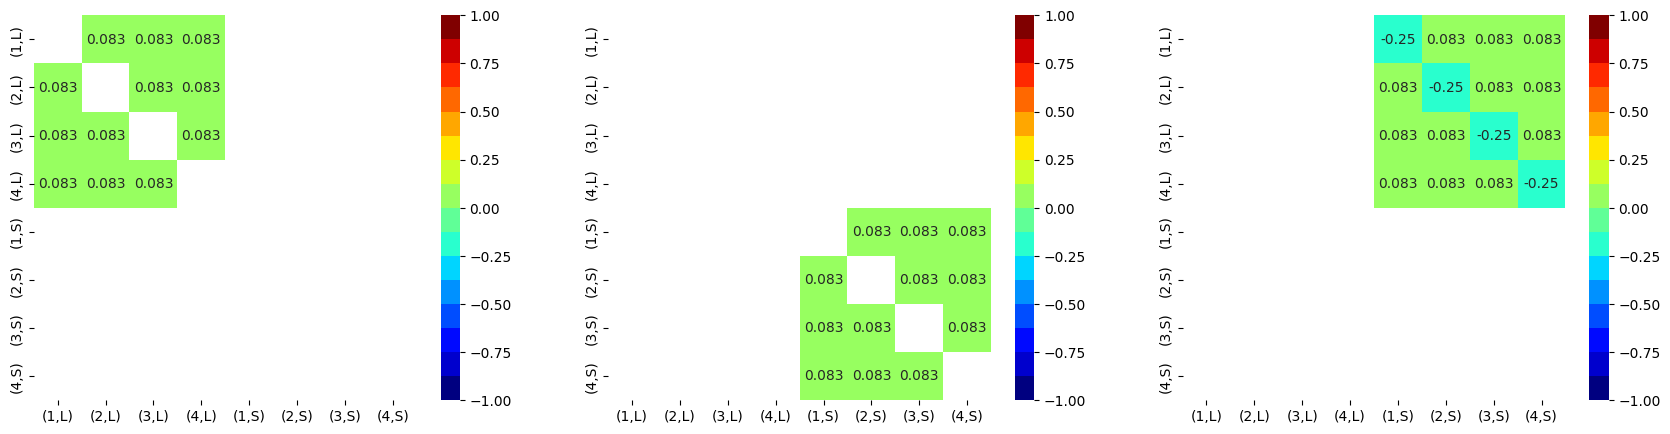

In [63]:
ncols, nrows = 3,1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols,5*nrows))

for ii, model in enumerate(tqdm(['letter', 'spatial', 'across'])):
    ## plot matrix
    ax = axs[ii]
    mat, mat_arr = return_mat(model)
    g = sns.heatmap(mat_arr, cmap=cm.jet.resampled(16), annot=True, vmin=-1, vmax=1, ax=ax)
    g.set_xticklabels(conditions[idx_arr])
    g.set_yticklabels(conditions[idx_arr])

100%|█████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.47s/it]


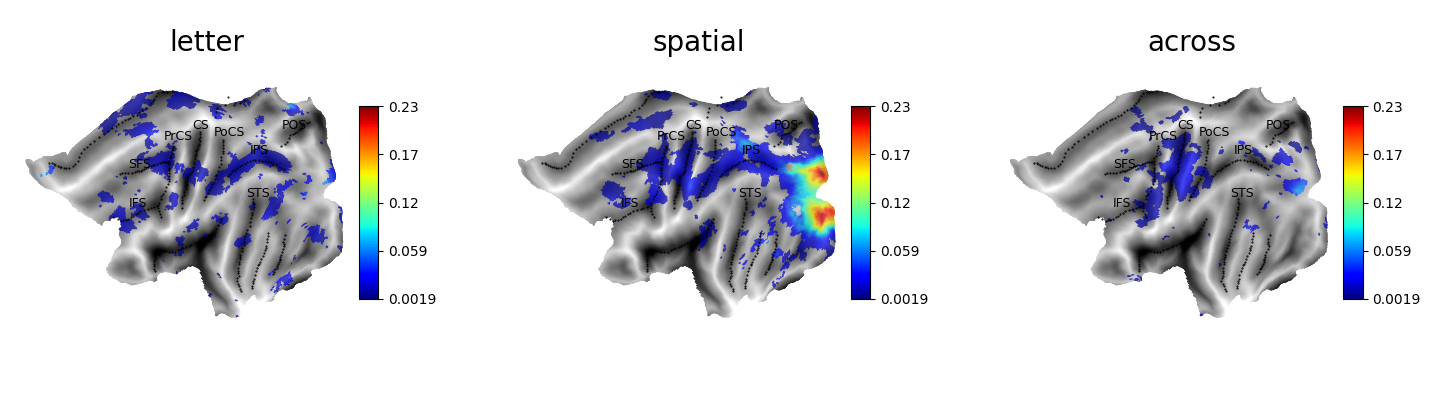

In [53]:
ncols, nrows = 3,1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,5*nrows))

for ii, model in enumerate(tqdm(['letter', 'spatial', 'across'])):
    plt.sca(axs[ii])
    ds = get_RDM(model, thresh)
    ## plot flat map
    cscale = None
    color = 'black'
    cscale = [0.0019, 0.23]
    g = surf.plot.plotmap(
        data=ds,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cm.jet, colorbar=True,
        cscale=cscale,
        # threshold=thresh,
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=40, y=250, s=model, ha='center', va='center', fontsize=20)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


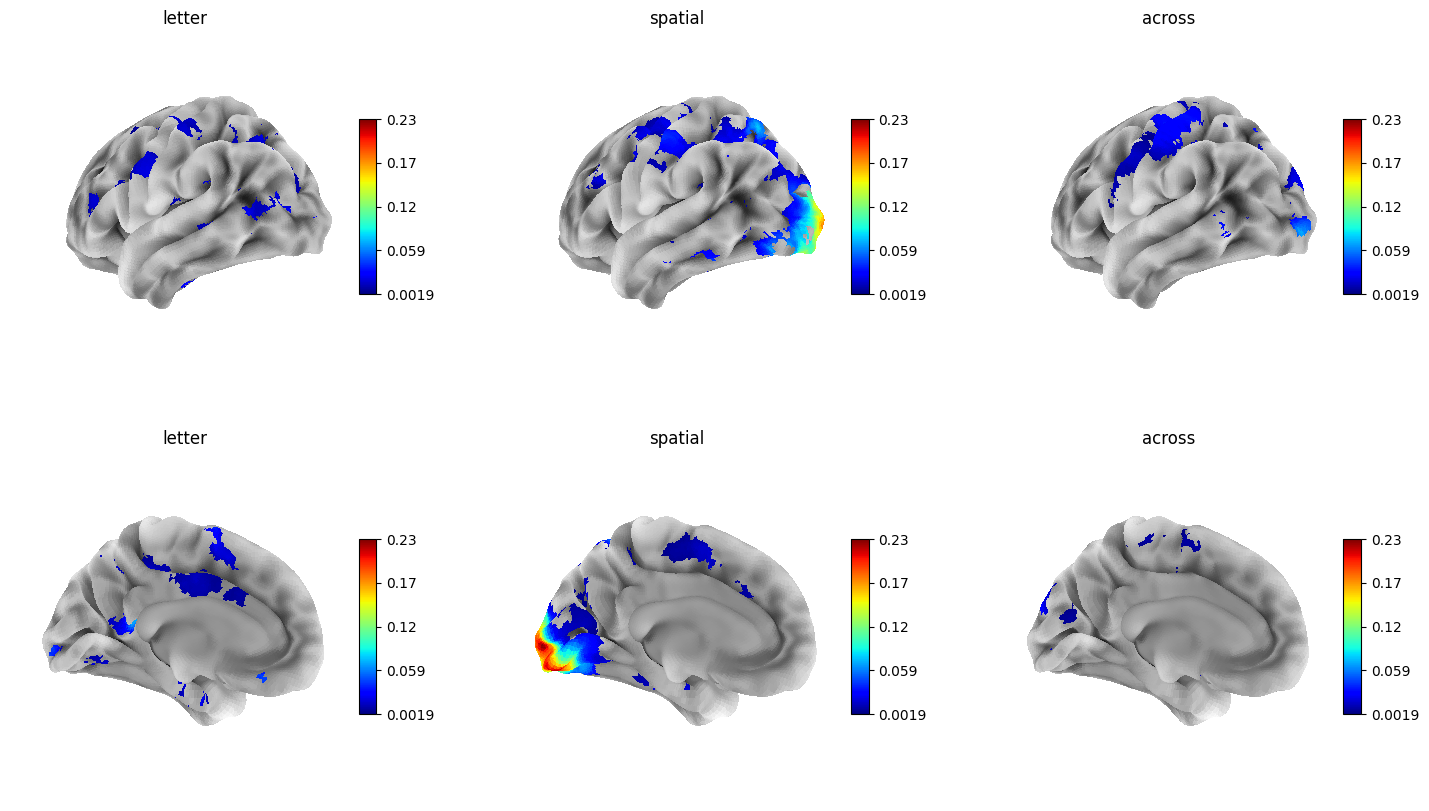

In [57]:
ncols, nrows = 3,2
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(6*ncols,5*nrows),
    subplot_kw={'projection': "3d"}
)
pial = join(dir_git,'fs_LR_32/fs_LR.32k.L.pial.surf.gii')
sulc = join(su.get_dir_surf(),'S01/S01.L.sulc.32k.shape.gii')
for ii, model in enumerate(tqdm(['letter', 'spatial', 'across'])):
    ## plot surface map
    ds = get_RDM(model, thresh)
    cscale = [0.0019, 0.23]
    
    ax = axs[0,ii]
    elev, azim = 0, 200
    g = plotting.plot_surf(
        surf_map=ds,
        surf_mesh=pial, bg_map=sulc,
        cmap=cm.jet, colorbar=True,
        vmin=cscale[0],vmax=cscale[1],
        cbar_vmin=cscale[0], cbar_vmax=cscale[1],
        hemi='left', view=(elev, azim),
        darkness=None,
        title=model,
        axes=ax
    )

    ax = axs[1,ii]
    elev, azim = 0, 0
    g = plotting.plot_surf(
        surf_map=ds,
        surf_mesh=pial, bg_map=sulc,
        cmap=cm.jet, colorbar=True,
        vmin=cscale[0],vmax=cscale[1],
        cbar_vmin=cscale[0], cbar_vmax=cscale[1],
        hemi='left', view=(elev, azim),
        darkness=None,
        title=model,
        axes=ax
    )

---

### Individual plotting

In [28]:
def plot_cue(cue):

    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(5*4,4*3))
    axs = np.concatenate(axs)
    
    for ii, sn in enumerate(tqdm(list_sn)):
        ax = axs[ii]
        plt.sca(ax)
    
        subj = 'S'+sn
        dir_work = join(dir_surf,'glm_%1d'%glm,subj)
        
        fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=200.h5'%(subj,hem))
        mySearchlight = sl.load(fname)
        
        ## check the indeces of centers
        idx = mySearchlight.center_indx
        
        data = np.zeros(32492)
        
        fname = join(dir_work, '%s.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,cue))
        cii = nb.load(fname)
        data[idx] = np.array(cii.get_fdata()[0])
        
        # vmax = max(abs(data.min()), data.max())
        vmax = 0.01
        vmin = -vmax
        
        color = 'black'
        g = surf.plot.plotmap(
            data=data,
            surf='fs32k_%s'%hem,
            alpha=0.7,
            cmap=cm.seismic, colorbar=True,
            cscale=[vmin, vmax],
            # threshold=[-thresh,thresh],
            borders=border, bordercolor=color, bordersize=1,
            overlay_type='func', render='matplotlib',
        )
        g.text(x=40, y=250, s=subj, ha='center', va='center', fontsize=20)
        for line, (x, y) in brdr.items():
            g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)
        fig.suptitle(cue, fontsize=24)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:51<00:00,  9.29s/it]


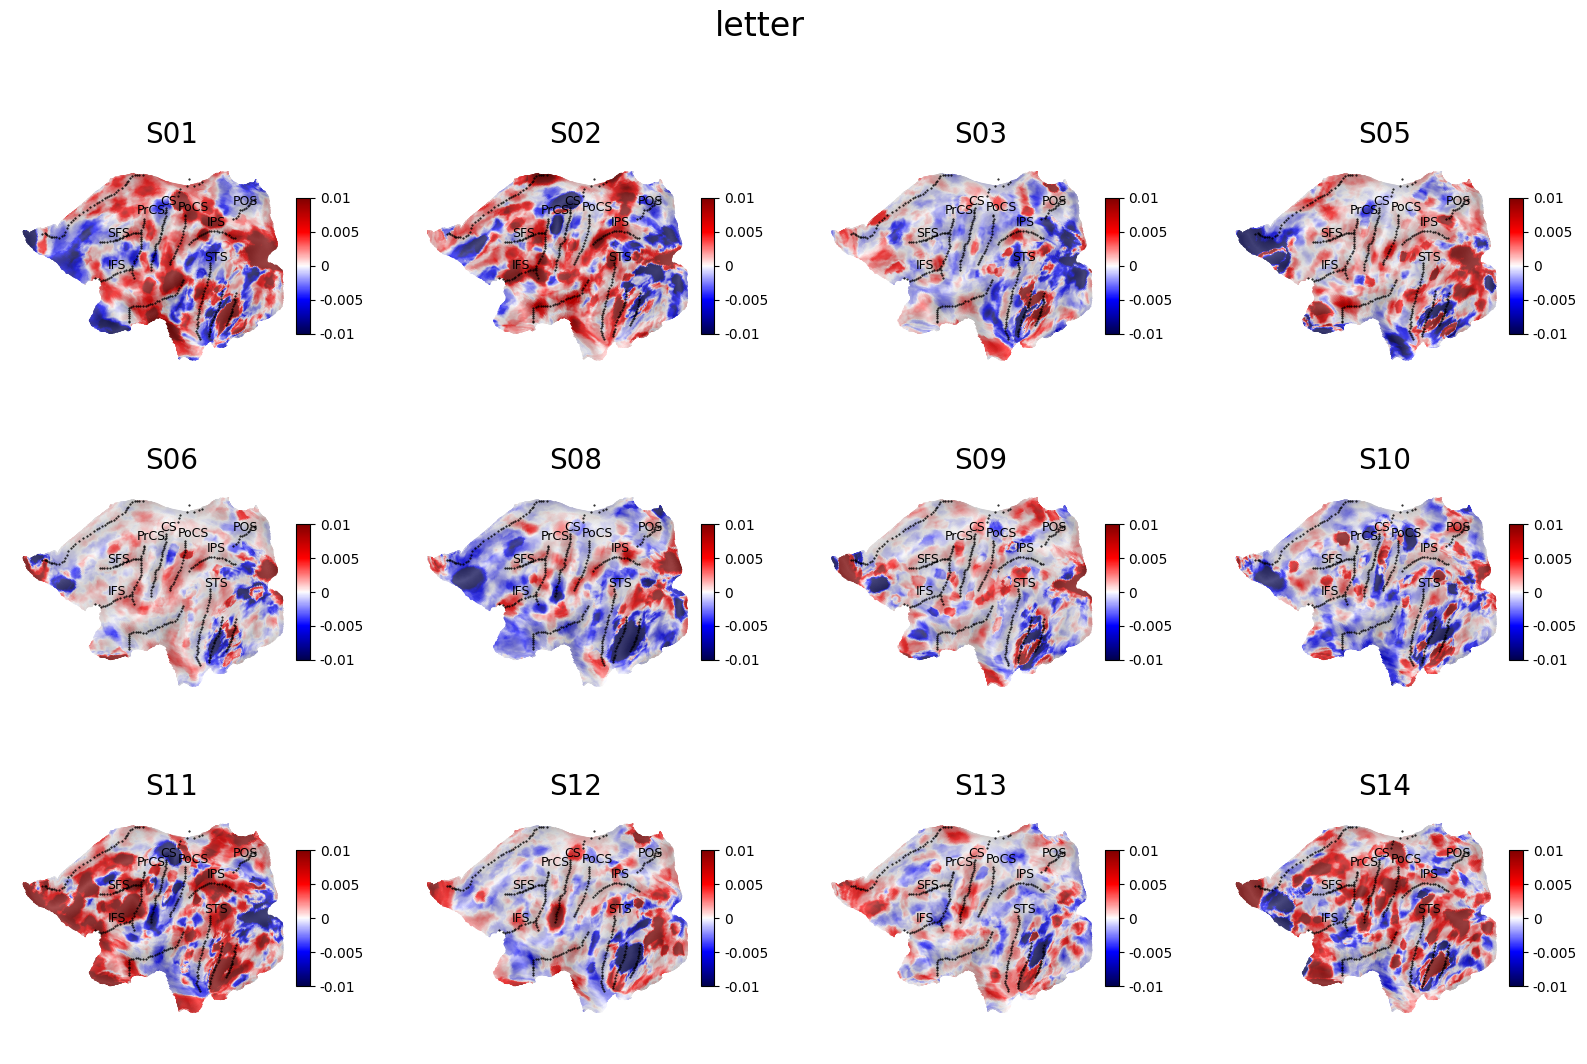

In [29]:
cue = 'letter'
plot_cue(cue)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:54<00:00,  9.51s/it]


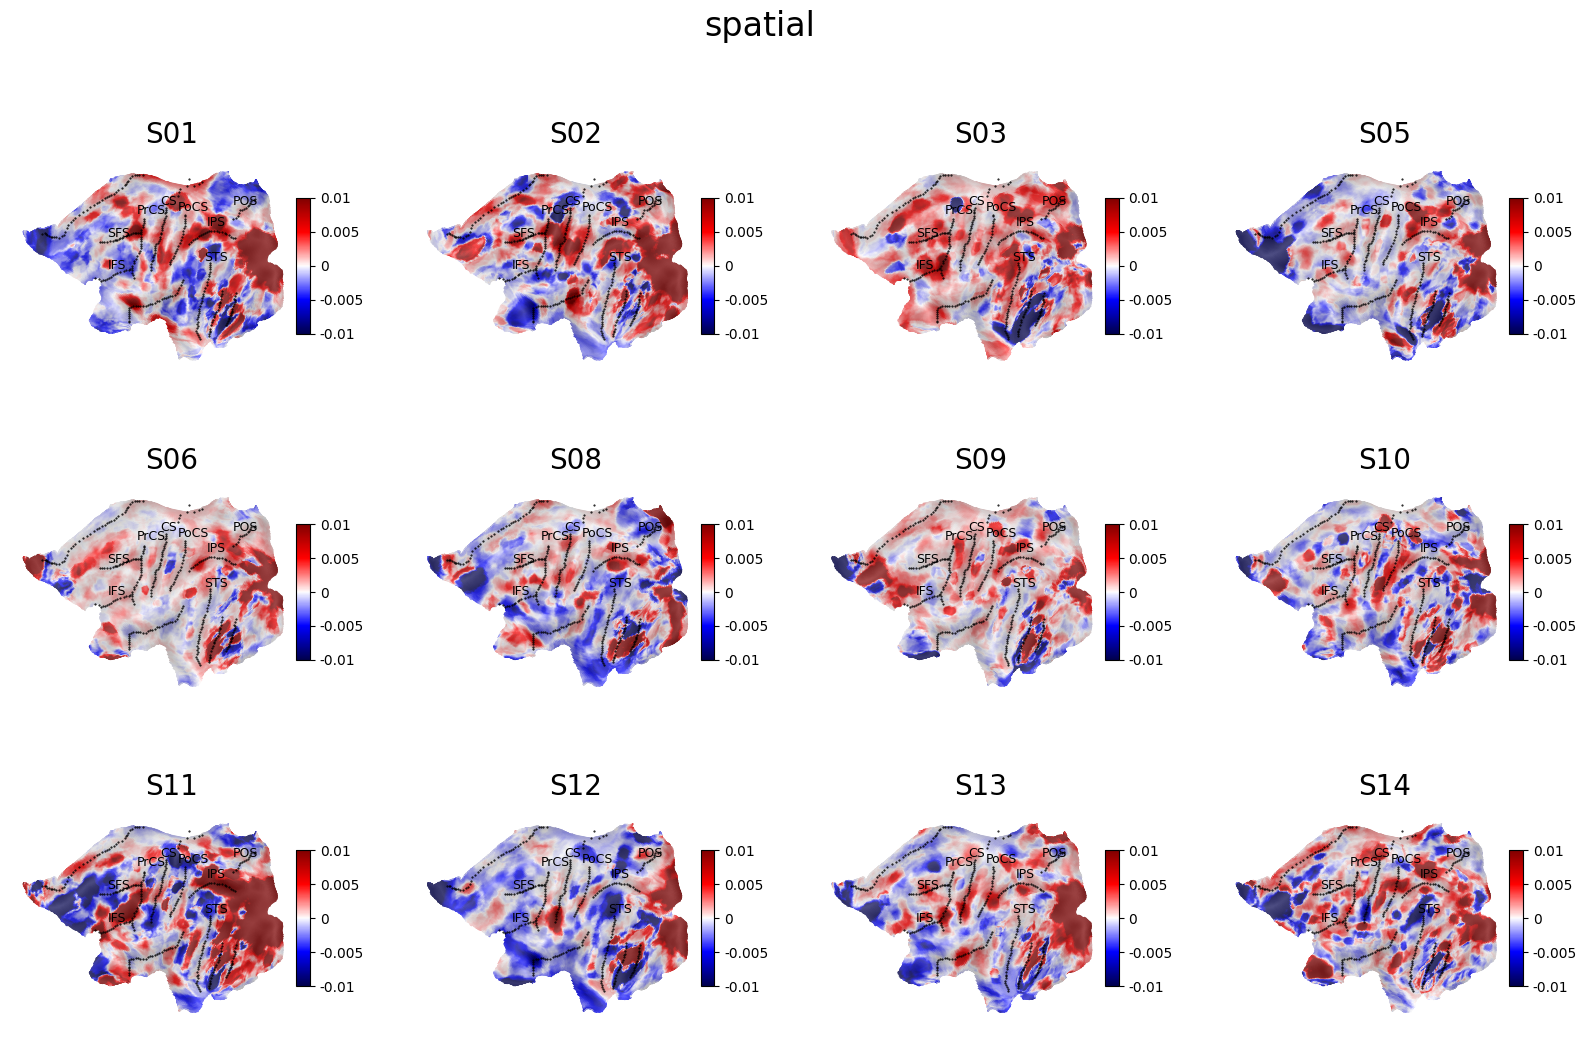

In [30]:
cue = 'spatial'
plot_cue(cue)

---